In [1]:
# ============================================================
# CIFAR-10 Simple Residual CNN (no Compose, with MinMaxScaler)
# 순서: 1) 데이터 로딩 → 2) 전처리 → 3) 모델 생성 → 4) 학습 → 5) 검증
# ============================================================

import math
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

from sklearn.preprocessing import MinMaxScaler  # 요구사항: sklearn MinMax 스케일러 사용

# -------------------------
# 공통 설정
# -------------------------
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_ROOT = './data'
BATCH_SIZE = 128
EPOCHS = 200
WARMUP_EPOCHS = 5
BASE_LR = 0.1 * (BATCH_SIZE / 128)
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
LABEL_SMOOTH = 0.1  # 깔끔한 일반화에 도움 (원하면 0.0으로 끄세요)

# ============================================================
# 1) 데이터 로딩 (질문 방식대로 ./data에 다운로드)
#    - transform=None (2단계에서 수동 전처리)
# ============================================================
train_base = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=True,  download=True, transform=None)
test_base  = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False, download=True, transform=None)

# ============================================================
# 2) 데이터 전처리 (augmentation, 스케일링 등)
#    - Compose 없이 "단계별" 수행
#    - RandomCrop(패딩 4, reflect), HorizontalFlip(0.5), 채널별 MinMaxScaler
#    - 스케일러는 "훈련셋 통계(채널별 min/max)"로 fit
# ============================================================

# (2-1) 채널별 min/max 추정: CIFAR10은 32x32x3, numpy 배열(train_base.data)을 그대로 사용 가능
train_np = train_base.data  # shape: (50000, 32, 32, 3), dtype uint8
ch_mins = train_np.reshape(-1, 3).min(axis=0).astype(np.float32)  # [minR, minG, minB]
ch_maxs = train_np.reshape(-1, 3).max(axis=0).astype(np.float32)  # [maxR, maxG, maxB]

# (2-2) 채널별 MinMaxScaler 준비 및 fit (훈련셋 기준)
scalers = [MinMaxScaler(feature_range=(0.0, 1.0)) for _ in range(3)]
for c in range(3):
    # MinMaxScaler는 2D 입력을 기대하므로, [min, max]를 세로 벡터로 제공
    scalers[c].fit(np.array([[ch_mins[c]], [ch_maxs[c]]], dtype=np.float32))

# (2-3) 수동 전처리를 수행하는 래퍼 Dataset 구현
class CIFAR10Preprocessed(torch.utils.data.Dataset):
    """
    Compose 없이 단계별 전처리:
      - (train) pad 4 (reflect) → RandomCrop(32,32) → RandomHorizontalFlip(0.5)
      - (both)  채널별 MinMaxScaler 적용 → Tensor (C,H,W)
    """
    def __init__(self, base_dataset, scalers, train=True):
        self.base = base_dataset
        self.scalers = scalers
        self.train = train

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]  # img: PIL.Image

        # --- 단계별 전처리 시작 ---
        # 1) (train 전용) 패딩 후 랜덤 크롭
        if self.train:
            # pad 4 (reflect)
            img = TF.pad(img, padding=4, padding_mode='reflect')
            # RandomCrop의 파라미터를 직접 뽑아 적용 (Compose 안 씀)
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(32, 32))
            img = TF.crop(img, i, j, h, w)
            # 2) (train 전용) 수평 뒤집기
            if random.random() < 0.5:
                img = TF.hflip(img)
        else:
            # test는 CIFAR10 원본이 이미 32x32라 별도 크롭/리사이즈 불필요
            pass

        # 3) numpy 변환 (H,W,C, float32, 0~255)
        arr = np.array(img, dtype=np.float32)  # (H,W,3)

        # 4) 채널별 MinMaxScaler 적용 (훈련셋 통계 기반)
        H, W, _ = arr.shape
        for c in range(3):
            ch = arr[..., c].reshape(-1, 1)               # (H*W,1)
            ch_scaled = self.scalers[c].transform(ch)     # [0,1] 스케일
            arr[..., c] = ch_scaled.reshape(H, W)

        # 5) Tensor 변환 (C,H,W)
        arr = np.transpose(arr, (2, 0, 1))  # (3,H,W)
        tensor = torch.from_numpy(arr).float()

        return tensor, label

# 래퍼 적용
train_dataset = CIFAR10Preprocessed(train_base, scalers, train=True)
test_dataset  = CIFAR10Preprocessed(test_base,  scalers, train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False,
                          num_workers=4, pin_memory=True)

# ============================================================
# 3) 모델 생성 — 간단한 CNN + Residual Block
#    - 채널 수를 작게(32→64→128) 유지해 "간단함"에 초점
#    - 각 stage 첫 블록에서 stride=2로 다운샘플
# ============================================================

def conv3x3(in_ch, out_ch, stride=1):
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_ch, out_ch, 1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            conv3x3(3, 32, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        # stages: (간단히 각 2블록)
        self.layer1 = nn.Sequential(
            BasicBlock(32, 32, stride=1),
            BasicBlock(32, 32, stride=1),
        )
        self.layer2 = nn.Sequential(
            BasicBlock(32, 64, stride=2),
            BasicBlock(64, 64, stride=1),
        )
        self.layer3 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128, stride=1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

        # He init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.stem(x)      # 32x32
        x = self.layer1(x)    # 32x32
        x = self.layer2(x)    # 16x16
        x = self.layer3(x)    # 8x8
        x = self.avgpool(x)   # 1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = SimpleResNet(num_classes=10).to(device)

# 옵티마이저/스케줄러/손실
optimizer = torch.optim.SGD(model.parameters(), lr=BASE_LR, momentum=MOMENTUM,
                            weight_decay=WEIGHT_DECAY, nesterov=True)

def lr_lambda(epoch):
    # Linear warmup → Cosine decay
    if epoch < WARMUP_EPOCHS:
        return float(epoch + 1) / float(WARMUP_EPOCHS)
    t = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
    return 0.5 * (1.0 + math.cos(math.pi * t))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ============================================================
# 4) 학습 루프
# ============================================================
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    n = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)

    scheduler.step()
    print(f"[Train] Epoch {epoch:03d} | loss={running_loss / max(1,n):.4f} | lr={scheduler.get_last_lr()[0]:.5f}")

# ============================================================
# 5) 검증
# ============================================================
@torch.no_grad()
def evaluate():
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        loss_sum += loss.item() * imgs.size(0)
        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return loss_sum / total, 100.0 * correct / total

# ============================================================
# 실행
# ============================================================
best_acc = 0.0
Path('checkpoints').mkdir(exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    train_one_epoch(epoch)
    if epoch % 5 == 0 or epoch == EPOCHS:
        tl, ta = evaluate()
        print(f"[Val/Test] Epoch {epoch:03d} | loss={tl:.4f} | acc={ta:.2f}%")
        if ta > best_acc:
            best_acc = ta
            torch.save(model.state_dict(), 'checkpoints/simple_rescnn_cifar10_best.pth')
            print(f"  ↳ New best saved ({best_acc:.2f}%).")

print(f"Done. Best Test Acc: {best_acc:.2f}%")


/tmp/ipykernel_678031/2544910072.py:218: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_678031/2544910072.py:233: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Train] Epoch 001 | loss=1.7121 | lr=0.04000
[Train] Epoch 002 | loss=1.3696 | lr=0.06000
[Train] Epoch 003 | loss=1.2081 | lr=0.08000
[Train] Epoch 004 | loss=1.1088 | lr=0.10000
[Train] Epoch 005 | loss=1.0423 | lr=0.10000


/tmp/ipykernel_678031/2544910072.py:257: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Val/Test] Epoch 005 | loss=1.0999 | acc=74.55%
  ↳ New best saved (74.55%).
[Train] Epoch 006 | loss=0.9890 | lr=0.09999
[Train] Epoch 007 | loss=0.9544 | lr=0.09997
[Train] Epoch 008 | loss=0.9304 | lr=0.09994
[Train] Epoch 009 | loss=0.9118 | lr=0.09990
[Train] Epoch 010 | loss=0.8917 | lr=0.09984
[Val/Test] Epoch 010 | loss=0.9445 | acc=81.12%
  ↳ New best saved (81.12%).
[Train] Epoch 011 | loss=0.8804 | lr=0.09977
[Train] Epoch 012 | loss=0.8711 | lr=0.09968
[Train] Epoch 013 | loss=0.8596 | lr=0.09959
[Train] Epoch 014 | loss=0.8529 | lr=0.09948
[Train] Epoch 015 | loss=0.8470 | lr=0.09935
[Val/Test] Epoch 015 | loss=1.1309 | acc=72.64%
[Train] Epoch 016 | loss=0.8414 | lr=0.09922
[Train] Epoch 017 | loss=0.8381 | lr=0.09907
[Train] Epoch 018 | loss=0.8309 | lr=0.09891
[Train] Epoch 019 | loss=0.8322 | lr=0.09873
[Train] Epoch 020 | loss=0.8207 | lr=0.09855
[Val/Test] Epoch 020 | loss=0.9247 | acc=82.94%
  ↳ New best saved (82.94%).
[Train] Epoch 021 | loss=0.8226 | lr=0.09835
[

Exception in thread Thread-96 (_pin_memory_loop):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/opt/conda/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/li

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# 데이터 로딩

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # 데이터 증강 (패딩 후 랜덤 크롭)
    transforms.RandomHorizontalFlip(),         # 좌우 반전
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465),
    #                      (0.2023, 0.1994, 0.2010))  # CIFAR-10 평균/표준편차
])

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465),
    #                      (0.2023, 0.1994, 0.2010))
])

In [5]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

In [6]:
# train/val split
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

In [7]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 모델 생성

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [13]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습

In [14]:
# 로그 저장용 리스트
train_losses, train_accuracies, valid_losses, valid_accuracies = [], [], [], []

In [15]:
for epoch in range(50):                       # 총 40번 데이터셋을 반복
    model.train()                             # 학습 모드(드롭아웃/배치정규화 등 학습 동작 켜짐)
    running_loss = 0                          # 에폭 동안의 학습 손실 누적 변수
    train_correct, train_total = 0, 0         # (추가) 에폭 단위 Train Acc 계산용

    # ---- 미니배치 학습 루프 ----
    for inputs, labels in trainloader:        # DataLoader에서 (입력, 정답) 배치를 꺼냄
        inputs, labels = inputs.to(device), labels.to(device)  # 배치 텐서를 모델과 같은 장치로 이동
        optimizer.zero_grad()                 # 직전 step의 누적 gradient를 0으로 초기화
        outputs = model(inputs)               # 순전파: 모델이 logits(미규격화 점수) 출력
        loss = loss_fn(outputs, labels)       # 손실 계산(CrossEntropyLoss: softmax+NLL 통합)
        loss.backward()                       # 역전파: 각 파라미터의 gradient 계산
        optimizer.step()                      # 가중치 갱신(gradient를 이용해 한 스텝 업데이트)
        running_loss += loss.item()           # 현재 배치의 손실 값을 파이썬 float로 누적

        # (추가) 배치 예측으로 Train Acc 누적
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))  # 에폭 평균 학습 손실 기록 (배치 개수로 나눔)
    train_accuracies.append(100 * train_correct / train_total)     # 학습 정확도(%) 기록

    # ----- Validation -----
    model.eval()                              # 평가 모드(드롭아웃/BN 등 평가 동작)
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():                     # 평가 시에는 gradient 계산 비활성화(메모리/속도 이점)
        for inputs, labels in valloader:      # 검증 데이터 배치 반복
            inputs, labels = inputs.to(device), labels.to(device)  # 장치 정렬
            outputs = model(inputs)           # 순전파만 수행
            loss = loss_fn(outputs, labels)   # 검증 배치 손실
            val_loss += loss.item()           # 손실 누적
            _, predicted = torch.max(outputs, 1)     # 각 샘플의 최고 점수 클래스 인덱스
            total += labels.size(0)                  # 총 샘플 수 누적
            correct += (predicted == labels).sum().item()  # 맞춘 개수 누적

    valid_losses.append(val_loss / len(valloader))     # 에폭 평균 검증 손실 기록
    valid_accuracies.append(100 * correct / total)     # 검증 정확도(%) 기록

    # 진행 상황 출력(총 30에 맞추어 표기)
    print(f"Epoch {epoch+1}/50 : TRAIN[Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.2f}%], VALID[Loss: {valid_losses[-1]:.4f}, Acc: {valid_accuracies[-1]:.2f}%]")

Epoch 1/50 : TRAIN[Loss: 1.6876, Acc: 38.16%], VALID[Loss: 1.4905, Acc: 45.51%]
Epoch 2/50 : TRAIN[Loss: 1.4023, Acc: 49.08%], VALID[Loss: 1.3730, Acc: 49.56%]
Epoch 3/50 : TRAIN[Loss: 1.2792, Acc: 53.81%], VALID[Loss: 1.2377, Acc: 55.17%]
Epoch 4/50 : TRAIN[Loss: 1.1767, Acc: 57.91%], VALID[Loss: 1.1879, Acc: 56.92%]
Epoch 5/50 : TRAIN[Loss: 1.1035, Acc: 60.68%], VALID[Loss: 1.0998, Acc: 61.16%]
Epoch 6/50 : TRAIN[Loss: 1.0531, Acc: 62.27%], VALID[Loss: 1.1028, Acc: 61.18%]
Epoch 7/50 : TRAIN[Loss: 1.0103, Acc: 63.88%], VALID[Loss: 1.0078, Acc: 64.53%]
Epoch 8/50 : TRAIN[Loss: 0.9840, Acc: 65.04%], VALID[Loss: 0.9888, Acc: 65.27%]
Epoch 9/50 : TRAIN[Loss: 0.9512, Acc: 66.11%], VALID[Loss: 0.9581, Acc: 66.49%]
Epoch 10/50 : TRAIN[Loss: 0.9255, Acc: 67.28%], VALID[Loss: 0.9602, Acc: 66.41%]
Epoch 11/50 : TRAIN[Loss: 0.9083, Acc: 67.82%], VALID[Loss: 0.9604, Acc: 66.24%]
Epoch 12/50 : TRAIN[Loss: 0.8902, Acc: 68.50%], VALID[Loss: 0.9520, Acc: 67.13%]
Epoch 13/50 : TRAIN[Loss: 0.8705, Acc

# 학습결과 확인

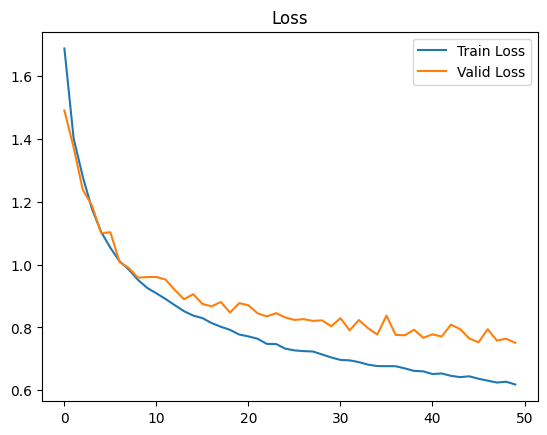

In [16]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.legend()
plt.title("Loss")
plt.show()

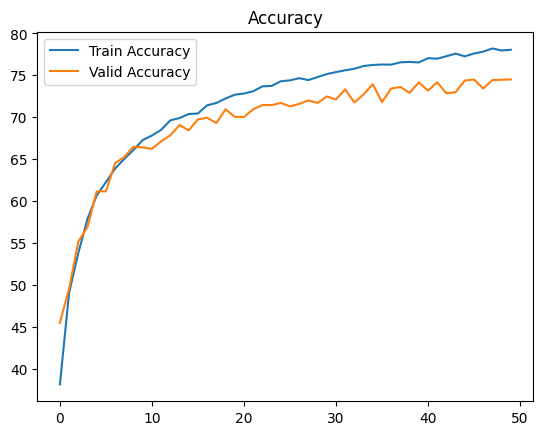

In [17]:
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(valid_accuracies, label="Valid Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [18]:
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

Test Accuracy: 77.23%
